# Import packages

In [12]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Import dataset

In [2]:
df = pd.read_csv("C:/Users/trung/CCDS/data/processed/df.csv")

df.head(5)

,name,year,poverty-rate,median-household-income,rent-burden,pct-white,households-threatened,eviction-filing-rate,total-crime
0,Baltimore City,2000,22.92,30078,26.9,30.96,58207.75,124.17,66791
1,Baltimore City,2001,22.92,30078,26.9,30.96,52564.67,111.08,64453
2,Baltimore City,2002,22.92,30078,26.9,30.96,57183.58,121.05,56550
3,Baltimore City,2003,22.92,30078,26.9,30.96,57039.41,116.82,49263
4,Baltimore City,2004,22.92,30078,26.9,30.96,60221.48,109.42,48314


# Data processing

In [3]:
# drop households-threatened variable
df = df.drop(columns="households-threatened", axis=1)

In [4]:
# rename columns to keep consistent format
df.rename(columns={"poverty-rate": "poverty_rate",
           "rent-burden": "rent_burden",
           "pct-white": "pct_white",
           "eviction-filing-rate": "eviction_filing_rate"
           }, inplace=True)

In [5]:
# create a metropolitan column indicating whether a jurisdiction is metropolitan
metro_jurisdictions = [
    "Frederick County",
    "Montgomery County",
    "Prince George's County"
]

df['metropolitan'] = df['name'].isin(metro_jurisdictions).astype(int)

In [6]:
# Log transform income, crime, poverty rate and eviction filing rate variable
df['log_income'] = np.log(df['median-household-income'])

# Log crime (+1 to allow zeros) since some jurisdictions have low crime rate
df['log_crime'] = np.log(df['total-crime'] + 1)

# Log transform poverty rate
df['log_poverty'] = np.log(df['poverty_rate'])

# Log transform eviction filing rate
df['log_eviction'] = np.log(df['eviction_filing_rate'])

In [7]:
# Create a poverty × metro interaction variable
df['poverty_metro'] = df['poverty_rate'] * df['metropolitan']

# Baseline model: Pooled OLS

In [8]:
ols_vars = ['log_poverty', 'log_income', 'rent_burden', 'log_crime', 'pct_white']
X0 = sm.add_constant(df[ols_vars])
y = df['log_eviction']

# Cluster-robust SEs by county
model0 = sm.OLS(y, X0)
res0 = model0.fit(cov_type='cluster',
                  cov_kwds={"groups": df["name"]})

print("Model 0: Pooled OLS")
print(res0.summary())

Model 0: Pooled OLS
                            OLS Regression Results                            
Dep. Variable:           log_eviction   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     11.59
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           1.13e-05
Time:                        15:04:16   Log-Likelihood:                -305.17
No. Observations:                 456   AIC:                             622.3
Df Residuals:                     450   BIC:                             647.1
Df Model:                           5                                         
Covariance Type:              cluster                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.2068      4.

# Model 1: Jurisdiction and Year Fixed Effect

In [9]:
# Create fixed effect dummies
fe_entity = pd.get_dummies(df['name'], drop_first=True, dtype=float)
fe_year   = pd.get_dummies(df['year'], drop_first=True, dtype=float)

# Build design matrix
X1 = pd.concat([
    df[ols_vars],
    fe_year,
    fe_entity
], axis=1)

X1 = sm.add_constant(X1)
y = df['log_eviction']

# Run OLS with robust SE (HC3)
model1 = sm.OLS(y, X1).fit(cov_type="cluster",
                            cov_kwds={"groups": df["name"]})

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           log_eviction   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     3818.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           4.42e-36
Time:                        15:04:16   Log-Likelihood:                 307.95
No. Observations:                 456   AIC:                            -521.9
Df Residuals:                     409   BIC:                            -328.1
Df Model:                          46                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

C:\Users\trung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 46, but rank is 23
  warnings.warn('covariance of constraints does not have full '


# Model 2: Jurisdiction and Year Fixed Effect with Interaction Term

In [10]:
# Build design matrix
X2 = pd.concat([
    df[ols_vars],
    df['poverty_metro'],
    fe_year,
    fe_entity
], axis=1)

X2 = sm.add_constant(X2)
y = df['log_eviction']

# Run OLS with robust SE (HC3)
model2 = sm.OLS(y, X2).fit(cov_type="cluster",
                            cov_kwds={"groups": df["name"]})

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           log_eviction   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1352.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           6.69e-31
Time:                        15:04:17   Log-Likelihood:                 308.42
No. Observations:                 456   AIC:                            -520.8
Df Residuals:                     408   BIC:                            -323.0
Df Model:                          47                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

C:\Users\trung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 23
  warnings.warn('covariance of constraints does not have full '


# Model Diagnostic

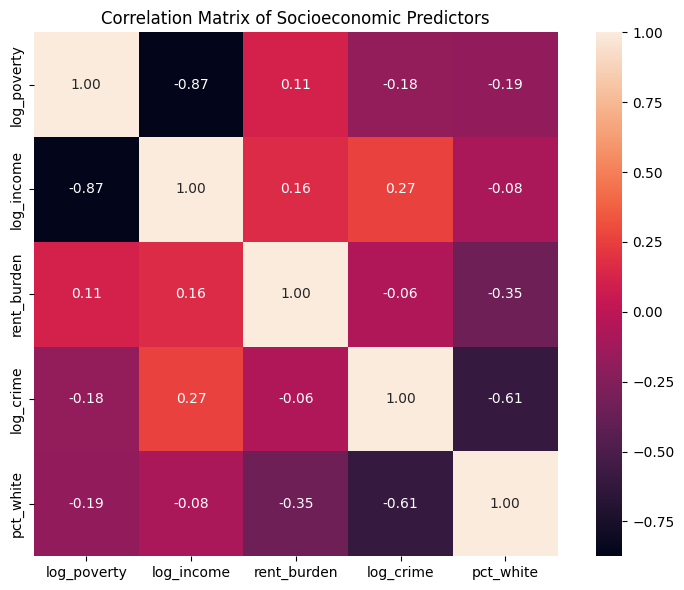

In [13]:
# check multicollinearity using Pearson correlation
corr_matrix = df[ols_vars].corr(method="pearson")

# plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", square=True)
plt.title("Correlation Matrix of Socioeconomic Predictors")
plt.tight_layout()
plt.show()